# 📊 Model Answer Analysis Dashboard

This notebook helps you analyze the detailed JSON results from your Optuna optimization pipeline.

**Key Questions We Can Answer:**
- Where does steering help but baseline fails?
- Where does baseline work but steering breaks it?
- What types of questions benefit most from steering?
- How do answer qualities compare between models?

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Define get_pattern function (used across multiple sections)
def get_pattern(row):
    """Get performance pattern for a row."""
    baseline = row['is_baseline_correct']
    steered = row['is_correct']
    
    if baseline and steered:
        return "Both Correct ✅✅"
    elif not baseline and not steered:
        return "Both Wrong ❌❌"
    elif not baseline and steered:
        return "Steering Helps 🎯✅"  # This is what you want!
    else:  # baseline and not steered
        return "Steering Hurts ✅❌"

print("📚 Libraries loaded successfully!")

📚 Libraries loaded successfully!


## 1. 📁 Load Your JSON Results

First, let's find and load your JSON files. Update the paths below to point to your actual result files.

In [2]:
# 🔧 Configure these paths to your actual files  
# Default paths - change these to your actual directories
BASE_DIR = Path("/workspace/wisent-guard/outputs/qwen_optimization")  # Absolute path
# Or use relative if running from project root: Path("outputs/optuna_minimal_example")

# Find all run directories (new timestamped structure)
run_dirs = sorted([d for d in BASE_DIR.glob("run_*") if d.is_dir()])
print(f"Found {len(run_dirs)} optimization runs")

if run_dirs:
    # Use the latest run by default
    RESULTS_DIR = run_dirs[-1]
    print(f"📁 Using latest run: {RESULTS_DIR.name}")
    
    # Find files in the latest run
    validation_files = sorted(RESULTS_DIR.glob("validation_detailed_results_*.json"))
    test_files = sorted(RESULTS_DIR.glob("test_detailed_results_*.json"))
    
    print(f"   - {len(validation_files)} validation files")
    print(f"   - {len(test_files)} test files") 
    
    if validation_files:
        print(f"   - Latest validation: {validation_files[-1].name}")
    if test_files:
        print(f"   - Latest test: {test_files[-1].name}")
        
    # 📊 Show all available runs for reference
    print(f"\n📋 All available runs:")
    for run_dir in run_dirs:
        val_count = len(list(run_dir.glob("validation_detailed_results_*.json")))
        test_count = len(list(run_dir.glob("test_detailed_results_*.json")))
        print(f"   - {run_dir.name}: {val_count} validation, {test_count} test files")
        
else:
    # Fallback to old flat structure
    RESULTS_DIR = BASE_DIR
    validation_files = sorted(RESULTS_DIR.glob("validation_detailed_results_*.json"))
    test_files = sorted(RESULTS_DIR.glob("test_detailed_results_*.json"))
    print(f"📁 Using flat structure: {len(validation_files)} validation, {len(test_files)} test files")

# 🔧 Or manually specify a specific run:
# RESULTS_DIR = BASE_DIR / "run_20250730_143000"  # Specific run directory
# validation_files = sorted(RESULTS_DIR.glob("validation_detailed_results_*.json"))
# test_files = sorted(RESULTS_DIR.glob("test_detailed_results_*.json"))

Found 3 optimization runs
📁 Using latest run: run_20250730_152550
   - 100 validation files
   - 1 test files
   - Latest validation: validation_detailed_results_trial_000_20250730_181416.json
   - Latest test: test_detailed_results_20250730_182045.json

📋 All available runs:
   - run_20250730_151831: 0 validation, 0 test files
   - run_20250730_152430: 0 validation, 0 test files
   - run_20250730_152550: 100 validation, 1 test files


In [3]:
# Load test results (most important for comparison)
if test_files:
    with open(test_files[-1], 'r') as f:
        test_data = json.load(f)
    
    test_df = pd.DataFrame(test_data)
    print(f"✅ Loaded test data: {len(test_df)} samples")
    print(f"Columns: {list(test_df.columns)}")
else:
    print("❌ No test files found. Run your optimization first!")
    test_df = None

✅ Loaded test data: 200 samples
Columns: ['row', 'question', 'correct_answer', 'baseline_model_answer', 'model_answer', 'is_baseline_correct', 'is_correct']


In [4]:
# Load validation results (optional - for trial analysis)
if validation_files:
    # Load the latest validation file
    with open(validation_files[-1], 'r') as f:
        val_data = json.load(f)
    
    val_df = pd.DataFrame(val_data)
    print(f"✅ Loaded validation data: {len(val_df)} samples")
    
    # Or load multiple validation files to compare trials
    all_val_data = []
    for i, file in enumerate(validation_files[-5:]):  # Last 5 trials
        with open(file, 'r') as f:
            data = json.load(f)
        for item in data:
            item['trial'] = i
            item['filename'] = file.name
        all_val_data.extend(data)
    
    all_val_df = pd.DataFrame(all_val_data)
    print(f"✅ Loaded multi-trial validation data: {len(all_val_df)} samples across {len(validation_files[-5:])} trials")
else:
    print("❌ No validation files found")
    val_df = None
    all_val_df = None

✅ Loaded validation data: 100 samples
✅ Loaded multi-trial validation data: 500 samples across 5 trials


## 2. 🔍 Quick Data Overview

In [5]:
if test_df is not None:
    print("📊 TEST RESULTS SUMMARY")
    print("=" * 50)
    
    # Basic stats
    baseline_correct = test_df['is_baseline_correct'].sum()
    steered_correct = test_df['is_correct'].sum()
    total = len(test_df)
    
    print(f"Total questions: {total}")
    print(f"Baseline correct: {baseline_correct}/{total} ({baseline_correct/total*100:.1f}%)")
    print(f"Steered correct: {steered_correct}/{total} ({steered_correct/total*100:.1f}%)")
    print(f"Improvement: {steered_correct - baseline_correct:+d} questions ({(steered_correct - baseline_correct)/total*100:+.1f}%)")
    
    # Show first few rows
    print("\n📋 First 3 samples:")
    display(test_df[['row', 'question', 'is_baseline_correct', 'is_correct']].head(3))

📊 TEST RESULTS SUMMARY
Total questions: 200
Baseline correct: 99/200 (49.5%)
Steered correct: 95/200 (47.5%)
Improvement: -4 questions (-2.0%)

📋 First 3 samples:


,row,question,is_baseline_correct,is_correct
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,False,True
1,1,A robe takes 2 bolts of blue fiber and half th...,True,True
2,2,Josh decides to try flipping a house. He buys...,False,False


## 3. 🎯 Key Analysis: Where Does Steering Help?

This is your main question - let's find cases where steering works but baseline fails!

🔍 PERFORMANCE PATTERNS
Both Wrong ❌❌: 70 questions (35.0%)
Both Correct ✅✅: 64 questions (32.0%)
Steering Hurts ✅❌: 35 questions (17.5%)
Steering Helps 🎯✅: 31 questions (15.5%)


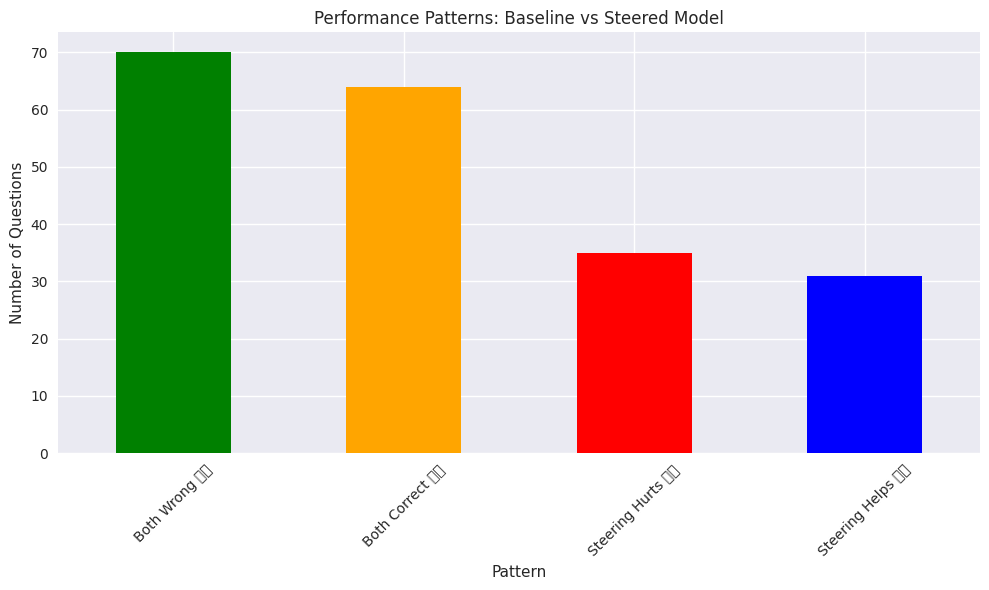

In [6]:
if test_df is not None:
    # Apply performance pattern categories
    test_df['pattern'] = test_df.apply(get_pattern, axis=1)
    
    # Count patterns
    pattern_counts = test_df['pattern'].value_counts()
    print("🔍 PERFORMANCE PATTERNS")
    print("=" * 50)
    for pattern, count in pattern_counts.items():
        percentage = count / len(test_df) * 100
        print(f"{pattern}: {count} questions ({percentage:.1f}%)")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    pattern_counts.plot(kind='bar', color=['green', 'orange', 'red', 'blue'])
    plt.title('Performance Patterns: Baseline vs Steered Model')
    plt.xlabel('Pattern')
    plt.ylabel('Number of Questions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 4. 🎯 Deep Dive: Cases Where Steering Helps

Let's examine the specific questions where steering works but baseline fails!

In [7]:
if test_df is not None:
    # Filter for cases where steering helps
    steering_helps = test_df[test_df['pattern'] == 'Steering Helps 🎯✅'].copy()
    
    print(f"🎯 FOUND {len(steering_helps)} CASES WHERE STEERING HELPS!")
    print("=" * 60)
    
    if len(steering_helps) > 0:
        for idx, row in steering_helps.iterrows():
            print(f"\n📝 Question {row['row']}:")
            print(f"❓ {row['question'][:100]}..." if len(row['question']) > 100 else f"❓ {row['question']}")
            print(f"✅ Correct Answer: {row['correct_answer']}")
            print(f"❌ Baseline Answer: {row['baseline_model_answer'][:80]}..." if len(str(row['baseline_model_answer'])) > 80 else f"❌ Baseline Answer: {row['baseline_model_answer']}")
            print(f"✅ Steered Answer: {row['model_answer'][:80]}..." if len(str(row['model_answer'])) > 80 else f"✅ Steered Answer: {row['model_answer']}")
            print("-" * 60)
    else:
        print("😔 No cases found where steering helps. This might indicate:")
        print("   - Steering parameters need tuning")
        print("   - The model is already well-tuned for this task")
        print("   - Different steering methods might work better")

🎯 FOUND 31 CASES WHERE STEERING HELPS!

📝 Question 0:
❓ Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for ...
✅ Correct Answer: 18
❌ Baseline Answer: To determine how much Janet makes every day at the farmers' market, we need to f...
✅ Steered Answer: First, we need to determine how many eggs are available for sale each day. Janet...
------------------------------------------------------------

📝 Question 4:
❓ Every day, Wendi feeds each of her chickens three cups of mixed chicken feed, containing seeds, meal...
✅ Correct Answer: 20
❌ Baseline Answer: To determine how many cups of feed Wendi needs to give her chickens in the final...
✅ Steered Answer: To determine how many cups of feed Wendi gives to her chickens in the final meal...
------------------------------------------------------------

📝 Question 18:
❓ Claire makes a 3 egg omelet every morning for breakfast.  How many dozens of eggs will she eat in 4 ...
✅ Correct Answer: 7
❌ B

## 5. ⚠️ Cases Where Steering Hurts

Let's also examine where steering breaks previously correct answers.

In [8]:
if test_df is not None:
    # Filter for cases where steering hurts
    steering_hurts = test_df[test_df['pattern'] == 'Steering Hurts ✅❌'].copy()
    
    print(f"⚠️ FOUND {len(steering_hurts)} CASES WHERE STEERING HURTS")
    print("=" * 60)
    
    if len(steering_hurts) > 0:
        for idx, row in steering_hurts.iterrows():
            print(f"\n📝 Question {row['row']}:")
            print(f"❓ {row['question'][:100]}..." if len(row['question']) > 100 else f"❓ {row['question']}")
            print(f"✅ Correct Answer: {row['correct_answer']}")
            print(f"✅ Baseline Answer: {row['baseline_model_answer'][:80]}..." if len(str(row['baseline_model_answer'])) > 80 else f"✅ Baseline Answer: {row['baseline_model_answer']}")
            print(f"❌ Steered Answer: {row['model_answer'][:80]}..." if len(str(row['model_answer'])) > 80 else f"❌ Steered Answer: {row['model_answer']}")
            print("-" * 60)
    else:
        print("😊 Great! Steering doesn't break any previously correct answers.")

⚠️ FOUND 35 CASES WHERE STEERING HURTS

📝 Question 5:
❓ Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second g...
✅ Correct Answer: 64
✅ Baseline Answer: To determine how much Kylar needs to pay for 16 glasses, we need to consider the...
❌ Steered Answer: To determine the total cost of 16 glasses, we need to calculate the cost of the ...
------------------------------------------------------------

📝 Question 6:
❓ Toulouse has twice as many sheep as Charleston. Charleston has 4 times as many sheep as Seattle. How...
✅ Correct Answer: 260
✅ Baseline Answer: To determine the total number of sheep that Toulouse, Charleston, and Seattle ha...
❌ Steered Answer: To find out how many sheep Toulouse, Charleston, and Seattle have together, we n...
------------------------------------------------------------

📝 Question 10:
❓ A new program had 60 downloads in the first month. The number of downloads in the second month was t...
✅ Correct Answer: 366


## 6. 📊 Answer Quality Analysis

Let's analyze the quality and patterns in the answers themselves.

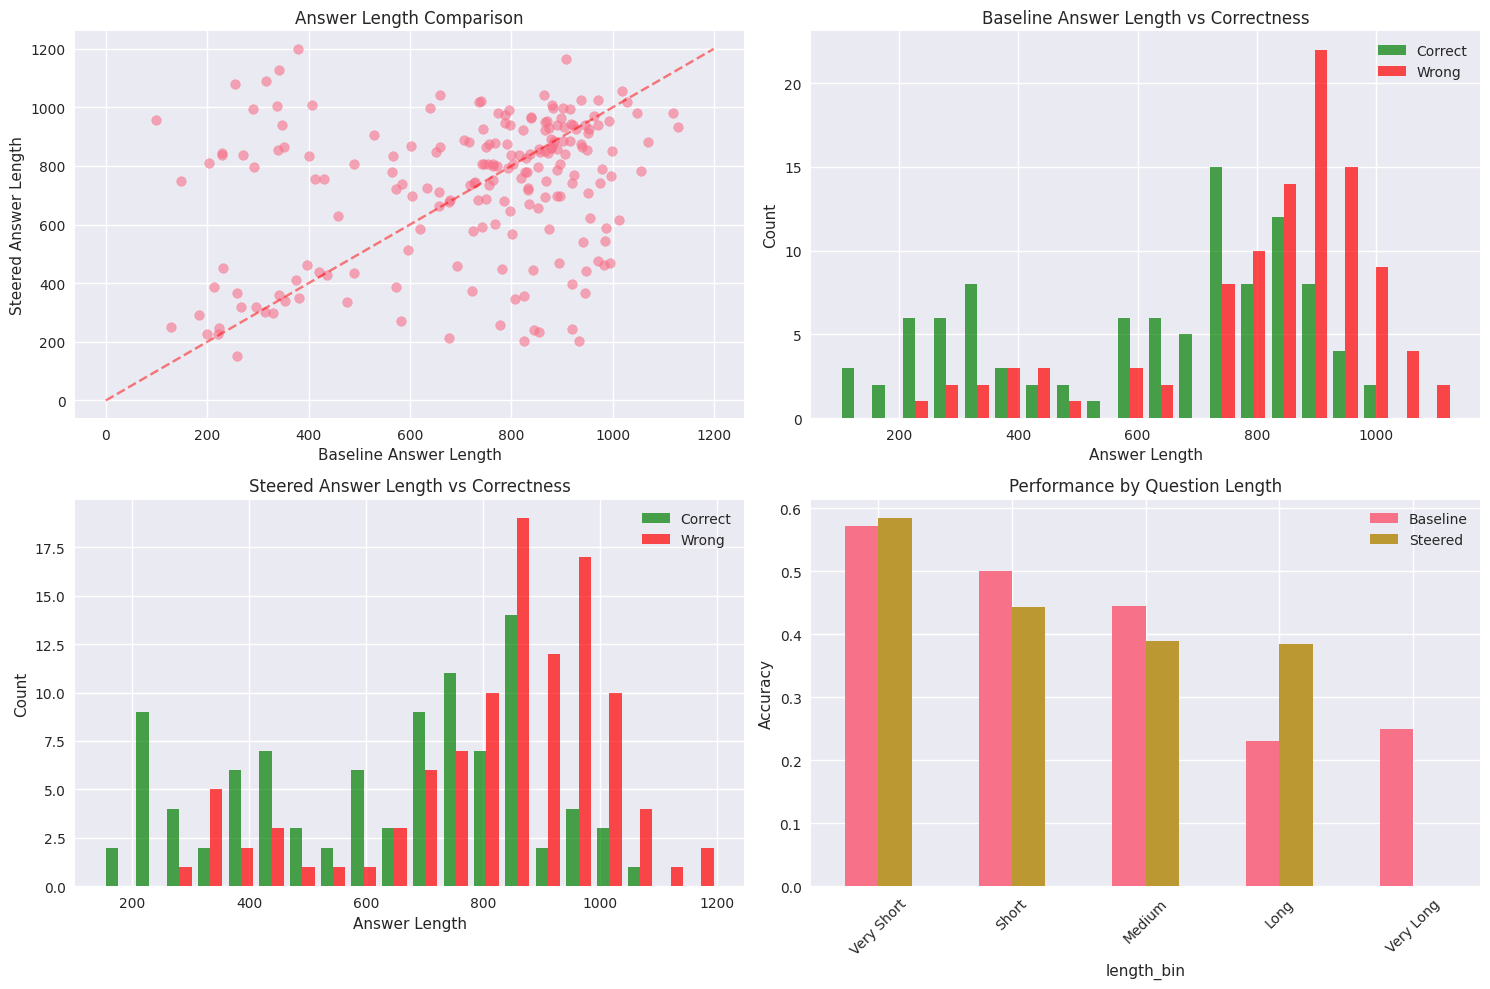


📊 ANSWER STATISTICS:
Average baseline answer length: 719.3 chars
Average steered answer length: 730.6 chars
Average question length: 242.4 chars


In [9]:
if test_df is not None:
    # Analyze answer lengths
    test_df['baseline_length'] = test_df['baseline_model_answer'].astype(str).str.len()
    test_df['steered_length'] = test_df['model_answer'].astype(str).str.len()
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Length comparison
    axes[0,0].scatter(test_df['baseline_length'], test_df['steered_length'], alpha=0.6)
    axes[0,0].plot([0, test_df[['baseline_length', 'steered_length']].max().max()], 
                   [0, test_df[['baseline_length', 'steered_length']].max().max()], 'r--', alpha=0.5)
    axes[0,0].set_xlabel('Baseline Answer Length')
    axes[0,0].set_ylabel('Steered Answer Length')
    axes[0,0].set_title('Answer Length Comparison')
    
    # Length distribution by correctness
    correct_baseline = test_df[test_df['is_baseline_correct']]['baseline_length']
    wrong_baseline = test_df[~test_df['is_baseline_correct']]['baseline_length']
    
    axes[0,1].hist([correct_baseline, wrong_baseline], bins=20, alpha=0.7, 
                   label=['Correct', 'Wrong'], color=['green', 'red'])
    axes[0,1].set_xlabel('Answer Length')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Baseline Answer Length vs Correctness')
    axes[0,1].legend()
    
    # Same for steered
    correct_steered = test_df[test_df['is_correct']]['steered_length']
    wrong_steered = test_df[~test_df['is_correct']]['steered_length']
    
    axes[1,0].hist([correct_steered, wrong_steered], bins=20, alpha=0.7, 
                   label=['Correct', 'Wrong'], color=['green', 'red'])
    axes[1,0].set_xlabel('Answer Length')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('Steered Answer Length vs Correctness')
    axes[1,0].legend()
    
    # Performance by question length
    test_df['question_length'] = test_df['question'].str.len()
    test_df['length_bin'] = pd.cut(test_df['question_length'], bins=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
    
    length_perf = test_df.groupby('length_bin')[['is_baseline_correct', 'is_correct']].mean()
    length_perf.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Performance by Question Length')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(['Baseline', 'Steered'])
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 ANSWER STATISTICS:")
    print(f"Average baseline answer length: {test_df['baseline_length'].mean():.1f} chars")
    print(f"Average steered answer length: {test_df['steered_length'].mean():.1f} chars")
    print(f"Average question length: {test_df['question_length'].mean():.1f} chars")